## 1. Import Library

In [1]:
import warnings

import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, f1_score, confusion_matrix
import seaborn as sns
import lightgbm as lgb
from optuna.integration import lightgbm as opt_lgb
import optuna
import matplotlib.pyplot as plt
import category_encoders as ce

warnings.simplefilter('ignore', pd.core.common.SettingWithCopyWarning)
warnings.simplefilter('ignore', UserWarning)
warnings.simplefilter('ignore', FutureWarning)

## 2. Load data

In [2]:
df_train = pd.read_csv("../data/train.csv")
df_test = pd.read_csv("../data/test.csv")
df_sample_sub = pd.read_csv("../data/sample_submit.csv")
df_sample_sub.columns = ["index", "genre"]
df_genre_labels = pd.read_csv("../data/genre_labels.csv")

## 3. Preparation

In [3]:
N_CLASSES = 11

In [4]:
def merge_train_test(df_train, df_test):
    if "genre" not in df_test.columns.tolist():
        df_test["genre"] = -100
    res = pd.concat([df_train, df_test])
    res.reset_index(inplace=True, drop=True)
    return res

def split_train_test(df):
    df_train = df[df["genre"] != -100]
    df_test = df[df["genre"] == -100]
    df_train.reset_index(inplace=True, drop=True)
    df_test.reset_index(inplace=True, drop=True)
    return df_train, df_test

df = merge_train_test(df_train, df_test)

### 4. Feature Engineering

### 4-1. 基本的な操作
- lgbm_knn_baselineと同様
    - tempo : tempo(meanで置き換え), tempo_low, tempo_high, tempo_div
    - region : one-hot-encoding, CE_region(count-encoding), LE_region(label-encoding)
    - num_nans
- 新たに追加
    - tempo : tempo_sum, tempo_diff
    - popularity : popularity01, popularity10

In [5]:
# genre_name
df["genre_name"] = df["genre"].map(dict(df_genre_labels[["labels", "genre"]].values))

# tempo
tempo = df["tempo"].str.split("-").apply(pd.Series).astype(float)
tempo.columns = ["tempo_low", "tempo_high"]
df = pd.concat([df, tempo], axis=1)

# df["tempo_sum"] = df["tempo_low"] + tempo["tempo_high"]
# df["tempo_diff"] = df["tempo_high"] - tempo["tempo_low"]
# df["tempo_div"] = df["tempo_low"] / tempo["tempo_high"]

# df["tempo_low"] = df["tempo_low"].replace(0.0, 0.001)
df["tempo"] = df["tempo"].map(lambda x: sum(map(int, x.split("-"))) / 2)

# region
df["region"] = df["region"].replace("unknown", "region_unknown")
df = pd.concat([df, pd.get_dummies(df["region"])], axis=1)

# num_nans
df["num_nans"] = 0
for col in ["acousticness", "positiveness", 
            "danceability", "energy", "liveness", 
            "speechiness", "instrumentalness"]:
    df["num_nans"] += df[col].isna()
    

# popularity
popularity = df["popularity"].astype(str).str.zfill(2)
popularity = [[i[0], i[1]] for i in popularity]
popularity = pd.DataFrame(popularity, columns=["popularity10", "popularity01"])
popularity = popularity.astype(int)
df = pd.concat([df, popularity], axis=1)
df

,index,genre,popularity,duration_ms,acousticness,positiveness,danceability,loudness,energy,liveness,...,region_O,region_P,region_Q,region_R,region_S,region_T,region_unknown,num_nans,popularity10,popularity01
0,0,10,11,201094,0.112811,0.157247,0.187841,-1.884852,0.893918,0.363568,...,0,0,0,0,0,0,0,0,1,1
1,1,8,69,308493,0.101333,0.346563,0.554444,-5.546495,0.874409,0.193892,...,0,0,0,0,0,0,0,0,6,9
2,2,3,43,197225,0.496420,0.265391,0.457642,-9.255670,0.439933,0.217146,...,0,0,0,0,0,0,0,0,4,3
3,3,10,45,301092,0.165667,0.245533,0.356578,-5.088788,0.868704,0.377025,...,0,0,0,0,0,0,0,0,4,5
4,4,3,57,277348,0.190720,0.777578,0.830479,-3.933896,0.650149,0.169323,...,0,0,0,0,0,0,1,0,5,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8087,8087,-100,34,366668,0.117208,0.316026,0.502289,-2.909329,0.824708,0.320241,...,0,0,0,0,0,0,0,0,3,4
8088,8088,-100,53,240081,0.225540,0.391226,0.483655,-5.013634,0.630808,0.163884,...,0,0,0,0,0,0,0,0,5,3
8089,8089,-100,48,217839,0.215571,0.828567,0.689747,-8.974036,0.697981,0.318250,...,0,0,0,0,0,0,0,0,4,8
8090,8090,-100,45,249612,0.205074,0.730554,0.580581,-1.915320,0.828423,0.360663,...,0,0,0,0,0,0,0,0,4,5


### 4-2. Encoder
- CountEncoder : region
- LabelEncoder : region

In [6]:
class CountEncoder:
    def fit(self, series):
        self.counts = series.groupby(series).count()
        return self
    
    def transform(self, series):
        return series.map(self.counts).fillna(0)
    
    def fit_transform(self, series):
        return self.fit(series).transform(series)
    
columns_count_enc = ["region"]
for col in columns_count_enc:
    df["CE_" + col] = CountEncoder().fit_transform(df[col])
    df.loc[df[col].isna().values, "CE_" + col] = np.nan


columns_label_enc = ["region"]
for col in columns_label_enc:
    df["LE_" + col] = LabelEncoder().fit_transform(df[col])
    df.loc[df[col].isna().values, "LE_" + col] = np.nan

df

,index,genre,popularity,duration_ms,acousticness,positiveness,danceability,loudness,energy,liveness,...,region_Q,region_R,region_S,region_T,region_unknown,num_nans,popularity10,popularity01,CE_region,LE_region
0,0,10,11,201094,0.112811,0.157247,0.187841,-1.884852,0.893918,0.363568,...,0,0,0,0,0,0,1,1,385.0,7.0
1,1,8,69,308493,0.101333,0.346563,0.554444,-5.546495,0.874409,0.193892,...,0,0,0,0,0,0,6,9,1573.0,8.0
2,2,3,43,197225,0.496420,0.265391,0.457642,-9.255670,0.439933,0.217146,...,0,0,0,0,0,0,4,3,1353.0,4.0
3,3,10,45,301092,0.165667,0.245533,0.356578,-5.088788,0.868704,0.377025,...,0,0,0,0,0,0,4,5,171.0,2.0
4,4,3,57,277348,0.190720,0.777578,0.830479,-3.933896,0.650149,0.169323,...,0,0,0,0,1,0,5,7,696.0,20.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8087,8087,-100,34,366668,0.117208,0.316026,0.502289,-2.909329,0.824708,0.320241,...,0,0,0,0,0,0,3,4,673.0,1.0
8088,8088,-100,53,240081,0.225540,0.391226,0.483655,-5.013634,0.630808,0.163884,...,0,0,0,0,0,0,5,3,1573.0,8.0
8089,8089,-100,48,217839,0.215571,0.828567,0.689747,-8.974036,0.697981,0.318250,...,0,0,0,0,0,0,4,8,385.0,7.0
8090,8090,-100,45,249612,0.205074,0.730554,0.580581,-1.915320,0.828423,0.360663,...,0,0,0,0,0,0,4,5,673.0,1.0


### 4-3. 集約特徴量
- regionの集約特徴量を作成
- min, mean, max, median, std, max-min, q75-q25, zscore

In [7]:
class GroupFeatureExtractor:  # 参考: https://signate.jp/competitions/449/discussions/lgbm-baseline-lb06240
    EX_TRANS_METHODS = ["deviation", "zscore"]
    
    def __init__(self, group_key, group_values, agg_methods):
        self.group_key = group_key
        self.group_values = group_values

        self.ex_trans_methods = [m for m in agg_methods if m in self.EX_TRANS_METHODS]
        self.agg_methods = [m for m in agg_methods if m not in self.ex_trans_methods]
        self.df_agg = None

    def fit(self, df_train, y=None):
        if not self.agg_methods:
            return
        dfs = []
        for agg_method in self.agg_methods:
            if callable(agg_method):
                agg_method_name = agg_method.__name__
            else:
                agg_method_name = agg_method
            df_agg = (df_train[[self.group_key] + self.group_values].groupby(self.group_key).agg(agg_method))
            df_agg.columns = self._get_column_names(agg_method_name)
            dfs.append(df_agg)
        self.df_agg = pd.concat(dfs, axis=1).reset_index()

    def transform(self, df_eval):
        key = self.group_key
        if self.agg_methods:
            df_features = pd.merge(df_eval[[self.group_key]], self.df_agg, on=self.group_key, how="left")
        else:
            df_features = df_eval[[self.group_key]].copy()
        if self.ex_trans_methods:
            if "deviation" in self.ex_trans_methods:
                df_features[self._get_agg_column_names("deviation")] = df_eval[self.group_values] - df_eval[[key]+self.group_values].groupby(key).transform("mean")
            if "zscore" in self.ex_trans_methods:
                df_features[self._get_column_names("zscore")] = (df_eval[self.group_values] - df_eval[[key]+self.group_values].groupby(key).transform("mean")) \
                                                                / (df_eval[[key]+self.group_values].groupby(key).transform("std") + 1e-8)
        df_features.drop(self.group_key, axis=1, inplace=True)
        return df_features

    def _get_column_names(self, method):
        return [f"agg_{method}_{col}_grpby_{self.group_key}" for col in self.group_values]

    def fit_transform(self, df_train, y=None):
        self.fit(df_train, y=y)
        return self.transform(df_train)   

# 集約特徴量作成時に使用
def max_min(x):
    return x.max() - x.min()

def q75_q25(x):
    return x.quantile(0.75) - x.quantile(0.25)
    
gfe = GroupFeatureExtractor(
    "region", 
    ['popularity', 'duration_ms', 'acousticness', 'positiveness', 
     'danceability', 'loudness', 'energy', 'liveness', 'speechiness', 
     'instrumentalness',
     'tempo', 'tempo_low', 'tempo_high',
     'popularity10', 'popularity01'], 
    ["min", "mean", "max", "median", "std", max_min, q75_q25, "zscore"]
)
df = pd.concat([df, gfe.fit_transform(df)], axis=1)
df

,index,genre,popularity,duration_ms,acousticness,positiveness,danceability,loudness,energy,liveness,...,agg_zscore_loudness_grpby_region,agg_zscore_energy_grpby_region,agg_zscore_liveness_grpby_region,agg_zscore_speechiness_grpby_region,agg_zscore_instrumentalness_grpby_region,agg_zscore_tempo_grpby_region,agg_zscore_tempo_low_grpby_region,agg_zscore_tempo_high_grpby_region,agg_zscore_popularity10_grpby_region,agg_zscore_popularity01_grpby_region
0,0,10,11,201094,0.112811,0.157247,0.187841,-1.884852,0.893918,0.363568,...,1.512742,1.361700,0.538449,2.294931,3.791753,0.511301,0.418672,0.591510,-1.159327,-1.044247
1,1,8,69,308493,0.101333,0.346563,0.554444,-5.546495,0.874409,0.193892,...,0.481851,1.326272,-0.499695,-0.500337,-0.587831,1.414210,1.479560,1.342325,1.425982,1.663014
2,2,3,43,197225,0.496420,0.265391,0.457642,-9.255670,0.439933,0.217146,...,-0.488448,-0.808778,-0.288703,1.980912,-0.252552,-1.797012,-1.634219,-1.934995,0.048978,-0.599708
3,3,10,45,301092,0.165667,0.245533,0.356578,-5.088788,0.868704,0.377025,...,0.312116,0.993184,0.833359,0.436282,-0.293784,1.817014,1.989646,1.634625,0.290296,0.103498
4,4,3,57,277348,0.190720,0.777578,0.830479,-3.933896,0.650149,0.169323,...,0.953197,0.195902,-0.617285,0.206761,0.088274,-0.510415,-0.496445,-0.519646,0.805682,0.951385
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8087,8087,-100,34,366668,0.117208,0.316026,0.502289,-2.909329,0.824708,0.320241,...,1.146514,0.970917,0.342260,0.222365,-0.121337,0.442081,0.345447,0.528850,-0.282831,-0.117197
8088,8088,-100,53,240081,0.225540,0.391226,0.483655,-5.013634,0.630808,0.163884,...,0.621439,0.050088,-0.688451,-0.007002,-0.156765,0.476541,0.374030,0.568536,0.825106,-0.433637
8089,8089,-100,48,217839,0.215571,0.828567,0.689747,-8.974036,0.697981,0.318250,...,-0.152429,0.484505,0.268481,-0.906510,-0.572775,0.511301,0.418672,0.591510,0.609527,1.448442
8090,8090,-100,45,249612,0.205074,0.730554,0.580581,-1.915320,0.828423,0.360663,...,1.383579,0.988935,0.595628,-0.343720,-0.360130,0.442081,0.345447,0.528850,0.353776,0.221316


### 4-4. KNN

In [8]:
class KNNFeatureExtractor:
    def __init__(self, n_neighbors=5):
        self.knn = KNeighborsClassifier(n_neighbors + 1)
    
    def fit(self, X, y):
        self.knn.fit(X, y)
        self.y = y if isinstance(y, np.ndarray) else np.array(y)
        return self
    
    def transform(self, X, is_train_data):
        distances, indexes = self.knn.kneighbors(X)
        distances = distances[:, 1:] if is_train_data else distances[:, :-1]
        indexes = indexes[:, 1:] if is_train_data else indexes[:, :-1]
        labels = self.y[indexes]
        score_columns = [f"knn_score_class{c:02d}" for c in range(N_CLASSES)]
        df_knn = pd.DataFrame(
            [np.bincount(labels_, distances_, N_CLASSES) for labels_, distances_ in zip(labels, 1.0 / distances)],
            columns=score_columns
        )
        df_knn["max_knn_scores"] = df_knn.max(1)
        for col in score_columns:
            df_knn[f"sub_max_knn_scores_{col}"] = df_knn["max_knn_scores"] - df_knn[col]
        for i, col1 in enumerate(score_columns):
            for j, col2 in enumerate(score_columns[i+1:], i+1):
                if {i, j} & {8, 10}:
                    df_knn[f"sub_{col1}_{col2}"] = df_knn[col1] - df_knn[col2]
        df_knn["sum_knn_scores"] = df_knn.sum(1)
        
        return df_knn

In [9]:
# feature scaling

df["log_tempo"] = np.log(df["tempo"])

for col in ['popularity', 'duration_ms', 'acousticness', 
            'positiveness', 'danceability', 'loudness', 
            'energy', 'liveness', 'speechiness', 'instrumentalness', 
            'log_tempo', 'num_nans']:
    df["standardscaled_" + col] = StandardScaler().fit_transform(df[[col]])[:, 0]

In [10]:
# feature weights

knn_features = ['region_A', 'region_B', 'region_C', 'region_D', 'region_E', 
            'region_F', 'region_G', 'region_H', 'region_I', 'region_J', 
            'region_K', 'region_L', 'region_M', 'region_N', 'region_O', 
            'region_P', 'region_Q', 'region_R', 'region_S', 'region_T',
            'region_unknown', 'standardscaled_popularity', 'standardscaled_duration_ms',
            'standardscaled_acousticness', 'standardscaled_positiveness',
            'standardscaled_danceability', 'standardscaled_loudness', 'standardscaled_energy',
            'standardscaled_liveness', 'standardscaled_speechiness', 'standardscaled_instrumentalness',
            'standardscaled_log_tempo',
            'standardscaled_num_nans']

dict_feature_weights = {}

for col in knn_features[:21]:
    dict_feature_weights[col] = 100.0

for col in ['standardscaled_duration_ms', 'standardscaled_acousticness', 'standardscaled_positiveness',
            'standardscaled_danceability', 'standardscaled_loudness', 'standardscaled_energy',
            'standardscaled_liveness', 'standardscaled_speechiness', 'standardscaled_instrumentalness']:
    dict_feature_weights[col] = 1.0

dict_feature_weights["standardscaled_popularity"] = 8.0
dict_feature_weights["standardscaled_log_tempo"] = 0.001
dict_feature_weights["standardscaled_num_nans"] = 100.0

knn_feature_weights = np.array([dict_feature_weights[col] for col in knn_features])

### 4-5. Target Encoding
-> 精度が低くなったので、今回はなし (cv=0.64468, lb=0.6289723713794166)

In [11]:
# trainとtestに再び分割

df_train, df_test = split_train_test(df)
target = df_train["genre"]

In [12]:
columns_target_enc = [
    'genre_1', 'genre_2', 'genre_3', 'genre_4', 
    'genre_5', 'genre_6', 'genre_7', 'genre_8', 
    'genre_9', 'genre_10', 'genre_11',
]

In [13]:
# target encoding for test data

target_onehot = ce.OneHotEncoder().fit_transform(target.astype(str))
df_train = pd.concat([df_train, target_onehot], axis=1)

for col in columns_target_enc:
    # 学習データ全体で描くカテゴリにおけるtargetの平均を計算
    data_tmp = pd.DataFrame({"region": df_train["region"], col: df_train[col]})
    target_mean = data_tmp.groupby("region")[col].mean()
    # バリデーションデータのカテゴリを置換
    df_test.loc[:, col] = df_train["region"].map(target_mean)

df_test

,index,genre,popularity,duration_ms,acousticness,positiveness,danceability,loudness,energy,liveness,...,genre_2,genre_3,genre_4,genre_5,genre_6,genre_7,genre_8,genre_9,genre_10,genre_11
0,4046,-100,43,192465,0.559812,0.565035,0.522237,-12.217087,0.620510,0.389727,...,0.066298,0.038674,0.165746,0.154696,0.000000,0.138122,0.044199,0.000000,0.000000,0.000000
1,4047,-100,40,226536,0.134002,0.542547,0.493128,-2.612846,0.853089,0.163106,...,0.329787,0.106383,0.115691,0.013298,0.000000,0.051862,0.055851,0.000000,0.009309,0.001330
2,4048,-100,58,215385,0.140537,0.643086,0.533189,-3.439684,0.834416,0.429304,...,0.477465,0.111268,0.078873,0.012676,0.000000,0.026761,0.000000,0.001408,0.011268,0.000000
3,4049,-100,49,254494,0.266406,0.456733,0.410583,-10.830424,0.534261,0.151830,...,0.130952,0.000000,0.000000,0.011905,0.000000,0.011905,0.000000,0.000000,0.000000,0.000000
4,4050,-100,50,230934,0.351907,0.526235,0.645625,-9.099337,0.612474,0.319161,...,0.329730,0.072973,0.105405,0.037838,0.002703,0.081081,0.016216,0.016216,0.024324,0.008108
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4041,8087,-100,34,366668,0.117208,0.316026,0.502289,-2.909329,0.824708,0.320241,...,0.160458,0.068768,0.000000,0.002865,0.005731,0.100287,0.031519,0.106017,0.005731,0.094556
4042,8088,-100,53,240081,0.225540,0.391226,0.483655,-5.013634,0.630808,0.163884,...,0.140704,0.070352,0.000000,0.055276,0.000000,0.040201,0.160804,0.000000,0.015075,0.000000
4043,8089,-100,48,217839,0.215571,0.828567,0.689747,-8.974036,0.697981,0.318250,...,0.477465,0.111268,0.078873,0.012676,0.000000,0.026761,0.000000,0.001408,0.011268,0.000000
4044,8090,-100,45,249612,0.205074,0.730554,0.580581,-1.915320,0.828423,0.360663,...,0.000000,0.000000,0.000000,0.080000,0.000000,0.140000,0.000000,0.000000,0.000000,0.000000


## 5. Training
- optunaを用いてパラメータチューニング
- CrossValidation (n_splits=15)で学習

In [14]:
# parameters

learning_rate = 0.01
lgb_params = {
    "objective": "multiclass",
    "num_class": N_CLASSES,
    "metric": "multiclass",
    "learning_rate": learning_rate,
    "verbosity": -1,
    "seed": 42,
}

knn_n_neighbors = 6

In [15]:
N_SPLITS = 15
SEED_SKF = 42
np.random.seed(42)

skf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=SEED_SKF)
oof = np.zeros((len(df_train), N_CLASSES))
predictions = np.zeros((len(df_test), N_CLASSES))
df_feature_importance = pd.DataFrame()


features_numerical = [
    'popularity', 'duration_ms', 'acousticness',
    'positiveness', 'danceability', 'loudness', 'energy', 'liveness',
    'speechiness', 'instrumentalness', 
    # popularity features
    'popularity01', 'popularity10',
    # tempo features
    'tempo', 'tempo_low', 'tempo_high',
#     'tempo_sum', 'tempo_diff', 'tempo_div',
    # one hot encoding
    'region_A', 'region_B', 'region_C', 'region_D', 'region_E', 'region_F',
    'region_G', 'region_H', 'region_I', 'region_J', 'region_K', 'region_L',
    'region_M', 'region_N', 'region_O', 'region_P', 'region_Q', 'region_R',
    'region_S', 'region_T', 'region_unknown', 
#     # target encoding
#     'genre_1', 'genre_2', 'genre_3', 'genre_4', 
#     'genre_5', 'genre_6', 'genre_7', 'genre_8', 
#     'genre_9', 'genre_10', 'genre_11',
    # others
    'CE_region', 'num_nans',
    # z-score
    'agg_zscore_popularity_grpby_region',
    'agg_zscore_duration_ms_grpby_region',
    'agg_zscore_acousticness_grpby_region',
    'agg_zscore_positiveness_grpby_region',
    'agg_zscore_danceability_grpby_region',
    'agg_zscore_loudness_grpby_region', 'agg_zscore_energy_grpby_region',
    'agg_zscore_liveness_grpby_region',
    'agg_zscore_speechiness_grpby_region',
    'agg_zscore_instrumentalness_grpby_region',
    'agg_zscore_tempo_grpby_region',
    'agg_zscore_tempo_low_grpby_region',
    'agg_zscore_tempo_high_grpby_region',
#     'agg_zscore_popularity10_grpby_region',
#     'agg_zscore_popularity01_grpby_region',
#     # min
#     'agg_min_popularity_grpby_region',
#     'agg_min_duration_ms_grpby_region',
#     'agg_min_acousticness_grpby_region',
#     'agg_min_positiveness_grpby_region',
#     'agg_min_danceability_grpby_region',
#     'agg_min_loudness_grpby_region',
#     'agg_min_energy_grpby_region',
#     'agg_min_liveness_grpby_region',
#     'agg_min_speechiness_grpby_region',
#     'agg_min_instrumentalness_grpby_region',
#     'agg_min_tempo_grpby_region',
#     'agg_min_tempo_low_grpby_region',
#     'agg_min_tempo_high_grpby_region',
#     'agg_min_popularity10_grpby_region',
#     'agg_min_popularity01_grpby_region',
#     # mean
#     'agg_mean_popularity_grpby_region',
#     'agg_mean_duration_ms_grpby_region',
#     'agg_mean_acousticness_grpby_region',
#     'agg_mean_positiveness_grpby_region',
#     'agg_mean_danceability_grpby_region',
#     'agg_mean_loudness_grpby_region',
#     'agg_mean_energy_grpby_region',
#     'agg_mean_liveness_grpby_region',
#     'agg_mean_speechiness_grpby_region',
#     'agg_mean_instrumentalness_grpby_region',
#     'agg_mean_tempo_grpby_region',
#     'agg_mean_tempo_low_grpby_region',
#     'agg_mean_tempo_high_grpby_region',
#     'agg_mean_popularity10_grpby_region',
#     'agg_mean_popularity01_grpby_region',
#     # max
#     'agg_max_popularity_grpby_region',
#     'agg_max_duration_ms_grpby_region',
#     'agg_max_acousticness_grpby_region',
#     'agg_max_positiveness_grpby_region',
#     'agg_max_danceability_grpby_region',
#     'agg_max_loudness_grpby_region',
#     'agg_max_energy_grpby_region',
#     'agg_max_liveness_grpby_region',
#     'agg_max_speechiness_grpby_region',
#     'agg_max_instrumentalness_grpby_region',
#     'agg_max_tempo_grpby_region',
#     'agg_max_tempo_low_grpby_region',
#     'agg_max_tempo_high_grpby_region',
#     'agg_max_popularity10_grpby_region',
#     'agg_max_popularity01_grpby_region',
#     # median
#     'agg_median_popularity_grpby_region',
#     'agg_median_duration_ms_grpby_region',
#     'agg_median_acousticness_grpby_region',
#     'agg_median_positiveness_grpby_region',
#     'agg_median_danceability_grpby_region',
#     'agg_median_loudness_grpby_region',
#     'agg_median_energy_grpby_region',
#     'agg_median_liveness_grpby_region',
#     'agg_median_speechiness_grpby_region',
#     'agg_median_instrumentalness_grpby_region',
#     'agg_median_tempo_grpby_region',
#     'agg_median_tempo_low_grpby_region',
#     'agg_median_tempo_high_grpby_region',
#     'agg_median_popularity10_grpby_region',
#     'agg_median_popularity01_grpby_region',
#     # std
#     'agg_std_popularity_grpby_region',
#     'agg_std_duration_ms_grpby_region',
#     'agg_std_acousticness_grpby_region',
#     'agg_std_positiveness_grpby_region',
#     'agg_std_danceability_grpby_region',
#     'agg_std_loudness_grpby_region',
#     'agg_std_energy_grpby_region',
#     'agg_std_liveness_grpby_region',
#     'agg_std_speechiness_grpby_region',
#     'agg_std_instrumentalness_grpby_region',
#     'agg_std_tempo_grpby_region',
#     'agg_std_popularity10_grpby_region',
#     'agg_std_popularity01_grpby_region',
#     # max_min
#     'agg_max_min_popularity_grpby_region',
#     'agg_max_min_duration_ms_grpby_region',
#     'agg_max_min_acousticness_grpby_region',
#     'agg_max_min_positiveness_grpby_region',
#     'agg_max_min_danceability_grpby_region',
#     'agg_max_min_loudness_grpby_region',
#     'agg_max_min_energy_grpby_region',
#     'agg_max_min_liveness_grpby_region',
#     'agg_max_min_speechiness_grpby_region',
#     'agg_max_min_instrumentalness_grpby_region',
#     'agg_max_min_tempo_grpby_region',
#     'agg_max_min_tempo_low_grpby_region',
#     'agg_max_min_tempo_high_grpby_region',
#     'agg_max_min_popularity10_grpby_region',
#     'agg_max_min_popularity01_grpby_region',
#     # q75_q25
#     'agg_q75_q25_popularity_grpby_region',
#     'agg_q75_q25_duration_ms_grpby_region',
#     'agg_q75_q25_acousticness_grpby_region',
#     'agg_q75_q25_positiveness_grpby_region',
#     'agg_q75_q25_danceability_grpby_region',
#     'agg_q75_q25_loudness_grpby_region',
#     'agg_q75_q25_energy_grpby_region',
#     'agg_q75_q25_liveness_grpby_region',
#     'agg_q75_q25_speechiness_grpby_region',
#     'agg_q75_q25_instrumentalness_grpby_region',
#     'agg_q75_q25_tempo_grpby_region',
#     'agg_q75_q25_tempo_low_grpby_region',
#     'agg_q75_q25_tempo_high_grpby_region',
#     'agg_q75_q25_popularity10_grpby_region',
#     'agg_q75_q25_popularity01_grpby_region',
    # knn
    'knn_score_class00', 'knn_score_class01',
    'knn_score_class02', 'knn_score_class03', 'knn_score_class04',
    'knn_score_class05', 'knn_score_class06', 'knn_score_class07',
    'knn_score_class08', 'knn_score_class09', 'knn_score_class10',
    'max_knn_scores',
    'sub_max_knn_scores_knn_score_class00',
    'sub_max_knn_scores_knn_score_class01',
    'sub_max_knn_scores_knn_score_class02',
    'sub_max_knn_scores_knn_score_class03',
    'sub_max_knn_scores_knn_score_class04',
    'sub_max_knn_scores_knn_score_class05',
    'sub_max_knn_scores_knn_score_class06',
    'sub_max_knn_scores_knn_score_class07',
    'sub_max_knn_scores_knn_score_class08',
    'sub_max_knn_scores_knn_score_class09',
    'sub_max_knn_scores_knn_score_class10',
    'sub_knn_score_class00_knn_score_class08',
    'sub_knn_score_class00_knn_score_class10',
    'sub_knn_score_class01_knn_score_class08',
    'sub_knn_score_class01_knn_score_class10',
    'sub_knn_score_class02_knn_score_class08',
    'sub_knn_score_class02_knn_score_class10',
    'sub_knn_score_class03_knn_score_class08',
    'sub_knn_score_class03_knn_score_class10',
    'sub_knn_score_class04_knn_score_class08',
    'sub_knn_score_class04_knn_score_class10',
    'sub_knn_score_class05_knn_score_class08',
    'sub_knn_score_class05_knn_score_class10',
    'sub_knn_score_class06_knn_score_class08',
    'sub_knn_score_class06_knn_score_class10',
    'sub_knn_score_class07_knn_score_class08',
    'sub_knn_score_class07_knn_score_class10',
    'sub_knn_score_class08_knn_score_class09',
    'sub_knn_score_class08_knn_score_class10',
    'sub_knn_score_class09_knn_score_class10',
    'sum_knn_scores'
]
features_categorical = ["LE_region"]
features = features_numerical + features_categorical
print(len(features))

106


In [16]:
# Optunaにより得られた最適なパラメータ

tuning_params = {'objective': 'multiclass', 
                 'num_class': 11, 
                 'metric': 'multi_logloss', 
                 'learning_rate': 0.010181824967207102, 
                 'verbosity': -1, 
                 'seed': 42, 
                 'feature_pre_filter': False, 
                 'lambda_l1': 0.91970762160045, 
                 'lambda_l2': 0.00015502503216817458, 
                 'num_leaves': 5, 
                 'feature_fraction': 0.4, 
                 'bagging_fraction': 0.999275938433692, 
                 'bagging_freq': 2, 
                 'min_child_samples': 25}

In [17]:

for fold_, (indexes_trn, indexes_val) in enumerate(skf.split(df_train.values, target.values)):
    print(f"------------------------------ fold {fold_} ------------------------------")

    df_trn = df_train.loc[indexes_trn].reset_index(drop=True)
    df_val = df_train.loc[indexes_val].reset_index(drop=True)
    target_trn = target.loc[indexes_trn].reset_index(drop=True)
    target_val = target.loc[indexes_val].reset_index(drop=True)

    # make knn features
    X = df_trn[knn_features].fillna(0.0).values * knn_feature_weights
    knn_feature_extractor = KNNFeatureExtractor(knn_n_neighbors).fit(X, target_trn)
    df_trn = pd.concat([df_trn, knn_feature_extractor.transform(X, is_train_data=True)], axis=1)
    X = df_val[knn_features].fillna(0.0).values * knn_feature_weights
    df_val = pd.concat([df_val, knn_feature_extractor.transform(X, is_train_data=False)], axis=1)
    X = df_test[knn_features].fillna(0.0).values * knn_feature_weights
    df_test_knn_features = knn_feature_extractor.transform(X, is_train_data=False)
    for col in df_test_knn_features.columns:
        df_test[col] = df_test_knn_features[col]
            
            
    # target encoding for train data
    for col in columns_target_enc:
        # 学習データ全体で描くカテゴリにおけるtargetの平均を計算
        data_tmp = pd.DataFrame({"region": df_trn["region"], col: df_trn[col]})
        target_trn_mean = data_tmp.groupby("region")[col].mean()
        # バリデーションデータのカテゴリを置換
        df_val.loc[:, col] = df_trn["region"].map(target_trn_mean)
        
        # 学習データの変換後の値を格納する配列を準備
        tmp = np.repeat(np.nan, df_trn.shape[0])
        kf_encoding = StratifiedKFold(n_splits=4, shuffle=True, random_state=72)
        for idx_1, idx_2 in kf_encoding.split(df_trn, target_trn):
            # out-of-foldで各カテゴリにおける目的変数の平均を計算
            target_mean = data_tmp.iloc[idx_1].groupby("region")[col].mean()
            # 変換後の値を一時配列に格納
            tmp[idx_2] = df_trn["region"].iloc[idx_2].map(target_mean)

        df_trn.loc[:, col] = tmp
        if np.nan in tmp:
            print("--------------------NaN---------------------")
    

    lgb_train = lgb.Dataset(
        df_trn.loc[:, features],
        label=target_trn,
        feature_name=features,
        categorical_feature=features_categorical
    )
    lgb_valid = lgb.Dataset(
        df_val.loc[:, features],
        label=target_val,
        feature_name=features,
        categorical_feature=features_categorical
    )

    lgb_params["learning_rate"] = learning_rate + np.random.random() * 0.001  # おまじない
    num_round = 999999999
    model = lgb.train(
#         lgb_params,
        tuning_params,
        lgb_train, 
        num_round, 
        valid_sets=[lgb_train, lgb_valid], 
        verbose_eval=300,
        early_stopping_rounds=300 if num_round >= 1e8 else None,
        fobj=None,
        #feval=lgb_metric,
    )

    # cv
    prediction_round = model.best_iteration+150 if num_round >= 1e8 else num_round  # おまじない
    oof[indexes_val] = model.predict(df_val[features], num_iteration=prediction_round)

    # feature importance
    df_fold_importance = pd.DataFrame()
    df_fold_importance["feature"] = features
    df_fold_importance["importance"] = model.feature_importance()
    df_fold_importance["fold"] = fold_
    df_feature_importance = pd.concat([df_feature_importance, df_fold_importance], axis=0)

    # prediction for test data
    predictions += model.predict(df_test[features], num_iteration=prediction_round) / N_SPLITS
    print()

------------------------------ fold 0 ------------------------------
Training until validation scores don't improve for 300 rounds
[300]	training's multi_logloss: 0.653763	valid_1's multi_logloss: 0.890804
[600]	training's multi_logloss: 0.543114	valid_1's multi_logloss: 0.887624
Early stopping, best iteration is:
[404]	training's multi_logloss: 0.608454	valid_1's multi_logloss: 0.885443

------------------------------ fold 1 ------------------------------
Training until validation scores don't improve for 300 rounds
[300]	training's multi_logloss: 0.658983	valid_1's multi_logloss: 0.829366
[600]	training's multi_logloss: 0.545523	valid_1's multi_logloss: 0.836976
Early stopping, best iteration is:
[361]	training's multi_logloss: 0.629648	valid_1's multi_logloss: 0.827116

------------------------------ fold 2 ------------------------------
Training until validation scores don't improve for 300 rounds
[300]	training's multi_logloss: 0.656518	valid_1's multi_logloss: 0.841597
[600]	trai

## 6. Test & Visualization

CV score
  f1:  0.62661

              precision    recall  f1-score   support

           0       0.83      0.59      0.69        32
           1       0.60      0.43      0.50       205
           2       0.73      0.54      0.62       191
           3       0.78      0.76      0.77       362
           4       0.67      0.22      0.33        45
           5       0.70      0.47      0.56       126
           6       0.57      0.32      0.41        50
           7       0.65      0.59      0.62       334
           8       0.70      0.79      0.75      1305
           9       0.88      0.83      0.85        59
          10       0.77      0.82      0.79      1337

    accuracy                           0.73      4046
   macro avg       0.72      0.58      0.63      4046
weighted avg       0.72      0.73      0.72      4046



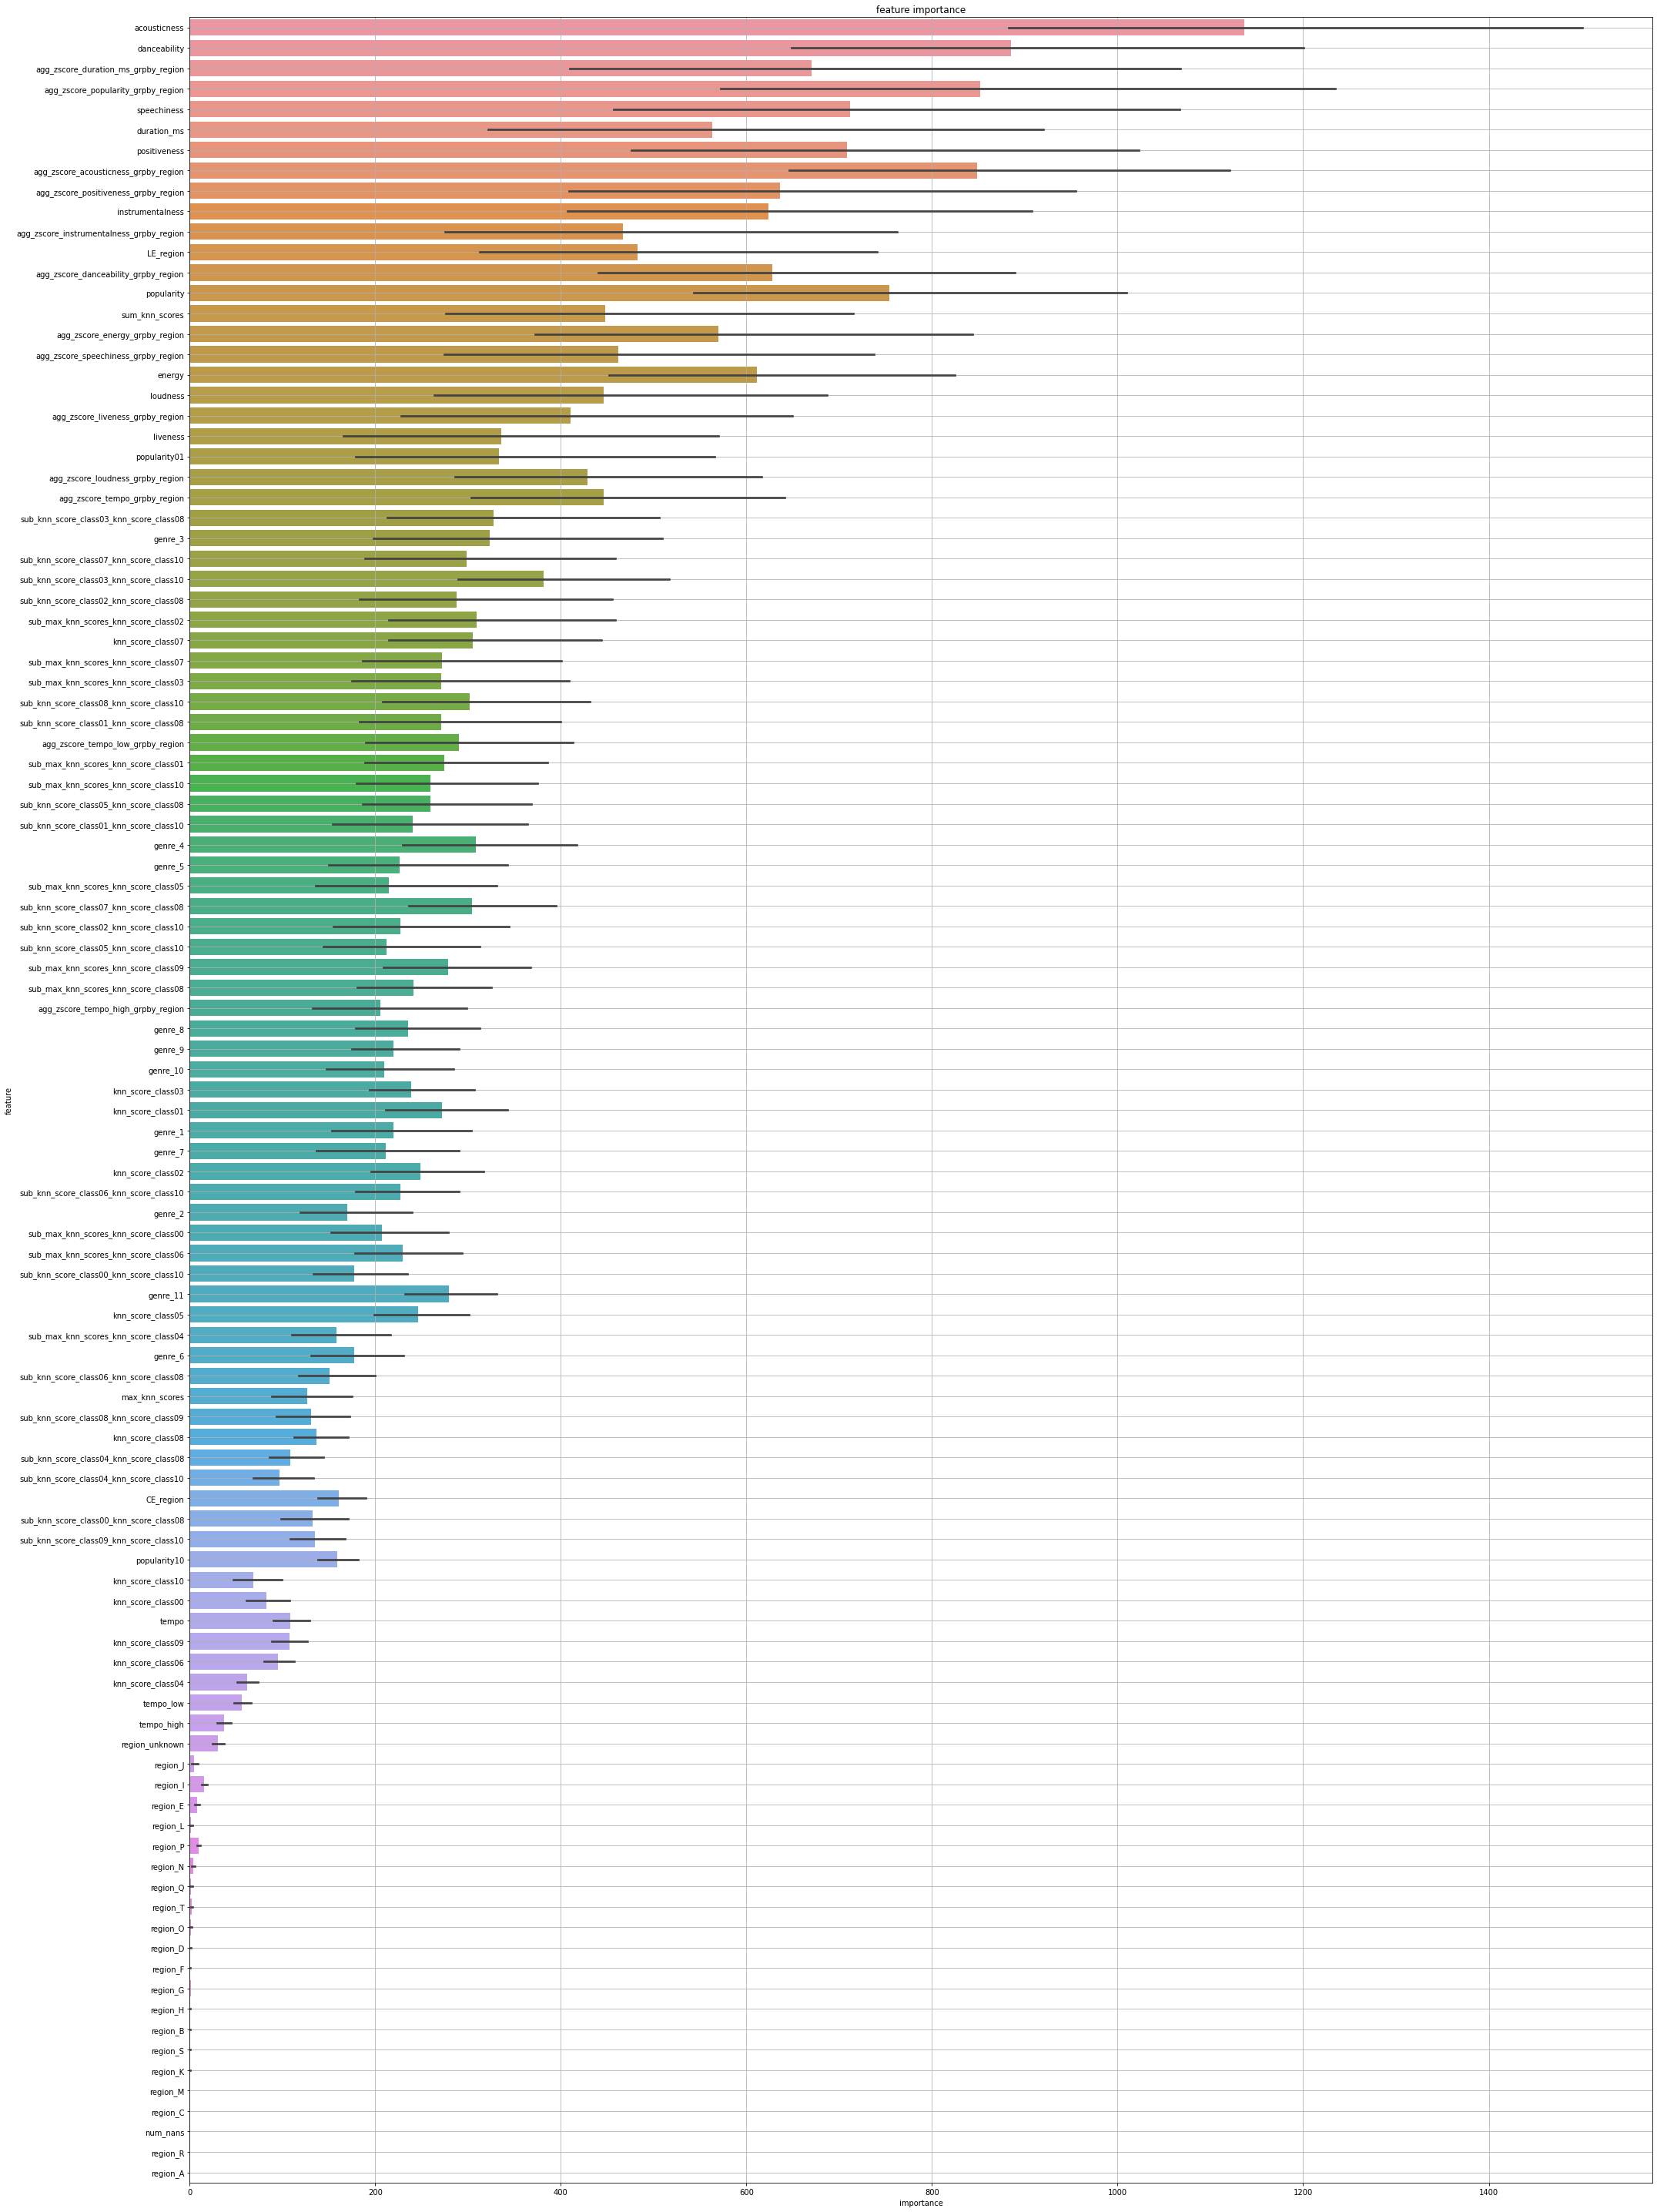

In [18]:
# df_test["prediction"] = predictions.argmax(1)
y_test = predictions.argmax(1)
score = f1_score(target, oof.argmax(1), average="macro")
print("CV score")
print(f"  f1: {score:8.5f}")
print()
print(classification_report(target, oof.argmax(1)))

plt.figure(figsize=(30, 40))
sns.barplot(x="importance", y="feature", data=df_feature_importance.sort_values(by="importance", ascending=False))
plt.title("feature importance")
plt.grid()
plt.tight_layout()
plt.show()

In [19]:
# feature importanceが0の特徴量
df_train.columns[np.where(model.feature_importance()==0)]

Index(['tempo_low', 'tempo_high', 'region_A', 'region_D', 'region_I',
       'region_J', 'region_K', 'region_M', 'region_O', 'region_P', 'region_Q',
       'agg_min_loudness_grpby_region'],
      dtype='object')

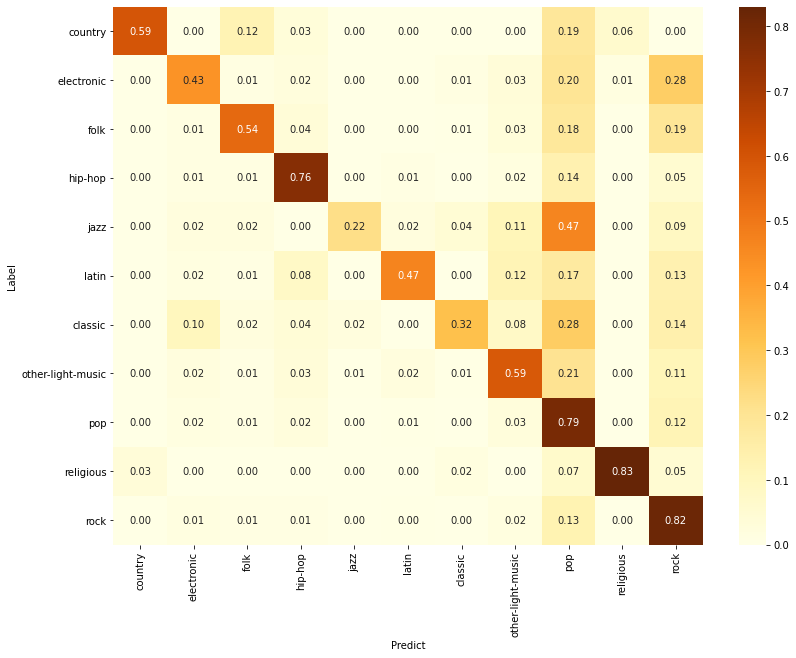

In [20]:
def visualize_confusion_matrix(y_true, pred_label, height=.6, labels=None):  # from https://signate.jp/competitions/449/discussions/lgbm-baseline-lb06240
    conf = confusion_matrix(y_true=y_true, y_pred=pred_label, normalize='true')

    n_labels = len(conf)
    size = n_labels * height
    fig, ax = plt.subplots(figsize=(size * 2, size * 1.5))
    sns.heatmap(conf, cmap='YlOrBr', ax=ax, annot=True, fmt='.2f')
    ax.set_ylabel('Label')
    ax.set_xlabel('Predict')

    if labels is not None:
        ax.set_yticklabels(labels)
        ax.set_xticklabels(labels)
        ax.tick_params('y', labelrotation=0)
        ax.tick_params('x', labelrotation=90)

    return fig

    
oof_label = pd.Series(np.argmax(oof, axis=1))
fig = visualize_confusion_matrix(y_true=target, pred_label=oof_label, labels=df_genre_labels["genre"])
plt.show(fig)

## 7. Save Result

In [21]:
# Save csv file
sample_submit = pd.read_csv("../data/sample_submit.csv", header=None)
submit = pd.concat([sample_submit.iloc[:, 0], pd.Series(y_test)], axis=1)
submit.columns = ["index", "genre"]

In [22]:
submit

,index,genre
0,4046,7
1,4047,10
2,4048,10
3,4049,8
4,4050,8
...,...,...
4041,8087,10
4042,8088,8
4043,8089,1
4044,8090,8


In [23]:
# submit.to_csv("../logs/test.csv", header=None, index=None)